In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from data_config import *
from functions import *
from exploration_functions import *

# Display graphs in notebook
%matplotlib inline

# Ignore harmless pandas back-end warnings
warnings.simplefilter("ignore")

### Overview

I chronologically separate the in-sample data into first and second parts, which are the training and validation sets, respectively. The training data contains all records excluding the last 24. The validation dataset includes only the last 24 records.

For each series id, I built a separate **set** of models. A series id's model set contains a separate model for each of the forecast horizon sizes (e.g., monthls 1 to 24 for the monthly data set). This approach performed reasonably better than the ARIMA-style recursive predictions where I made just one model per series id.

The models perform very well on the validation data. Below I show four separate monthly time series predictions on the validation data set. The light green shading represents the +/- mean absolute error (on the training data set) to get a rough approximation of forecast uncertainty.

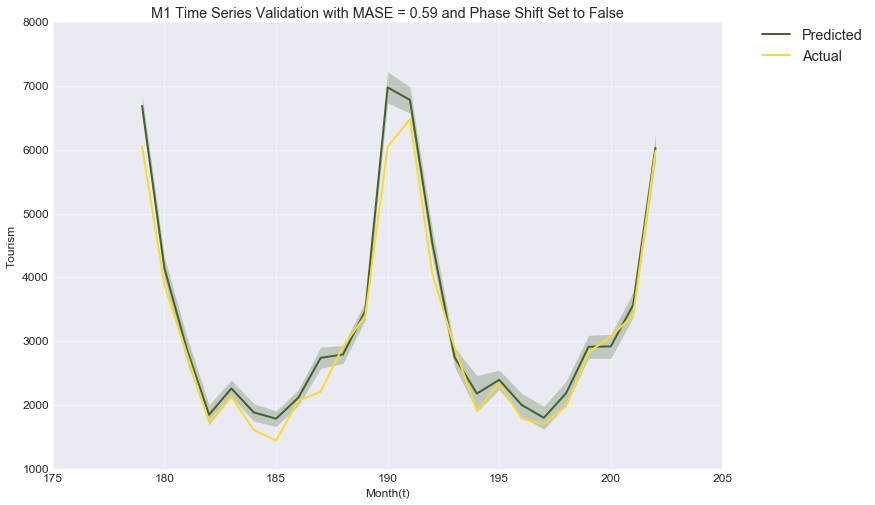

In [3]:
plot_predictions(series_id='m1',pred_type='validation',phase_shift=False)

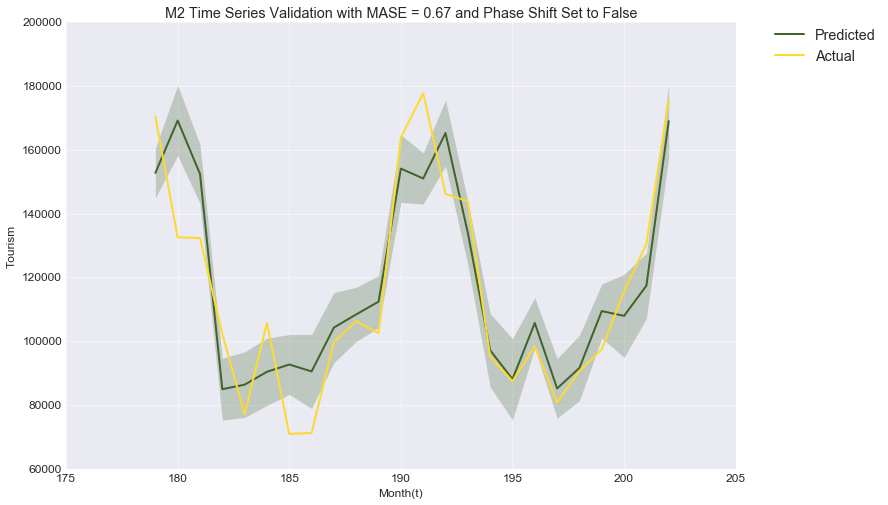

In [4]:
plot_predictions(series_id='m2',pred_type='validation',phase_shift=False)

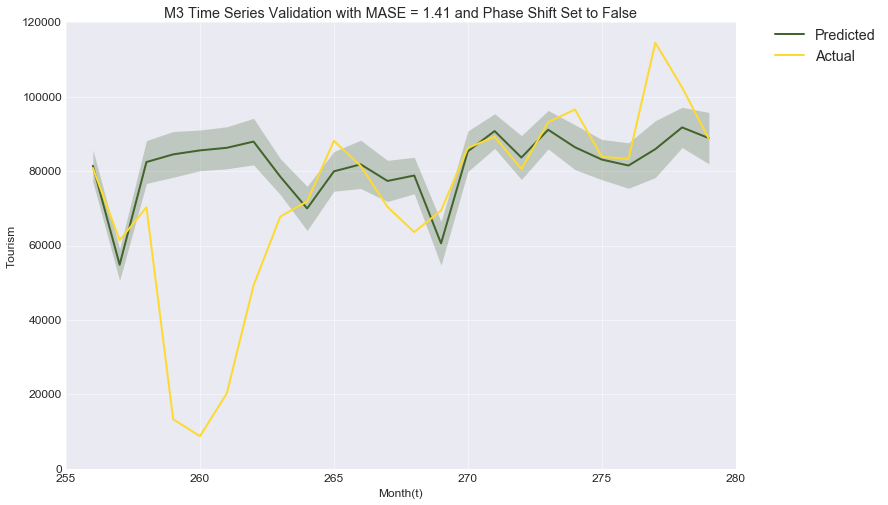

In [5]:
plot_predictions(series_id='m3',pred_type='validation',phase_shift=False)

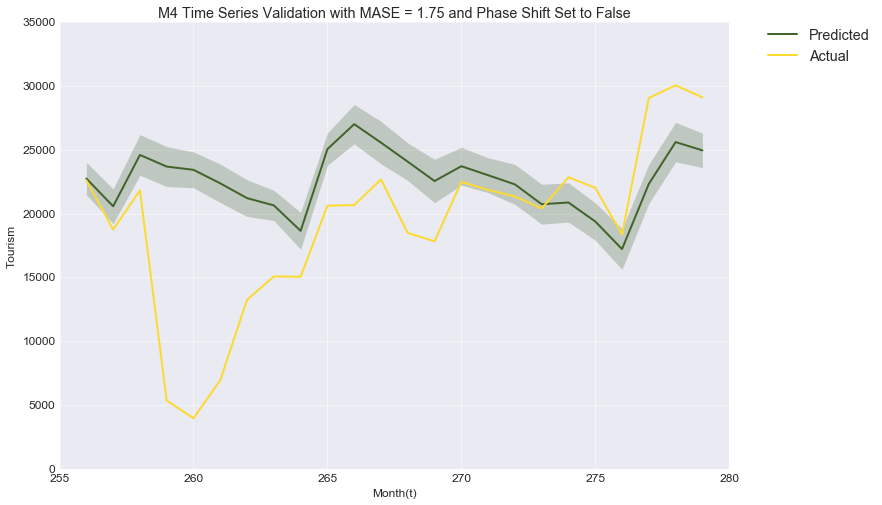

In [6]:
plot_predictions(series_id='m4',pred_type='validation',phase_shift=False)

### Awful OOS Performance?

I quickly noticed that the models had terrible peformance on the out-of-sample data. The figures below show that there seems to be some sort of phase shift. In general, the peakes are of the correct magnitude, but they're off by a consistent amount. The phase shift was consistent across all time series ids.

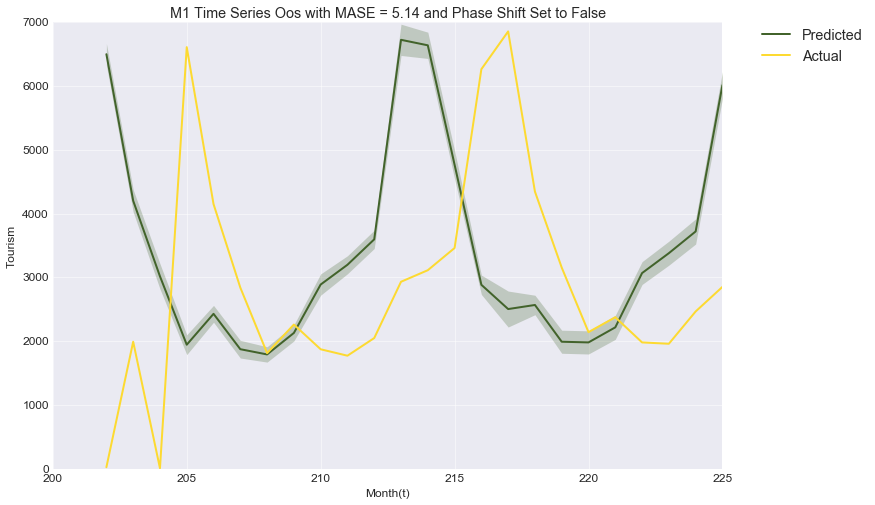

In [7]:
plot_predictions(series_id='m1',pred_type='oos',phase_shift=False)

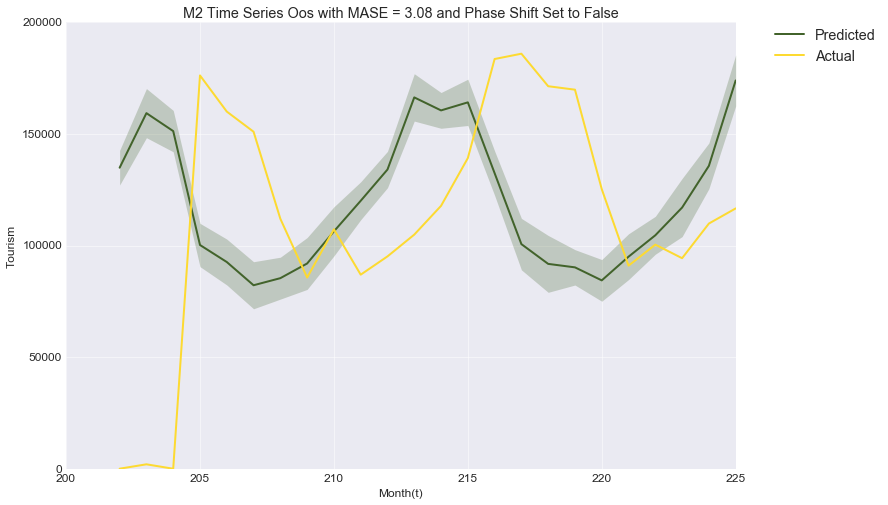

In [151]:
plot_predictions(series_id='m2',pred_type='oos',phase_shift=False)

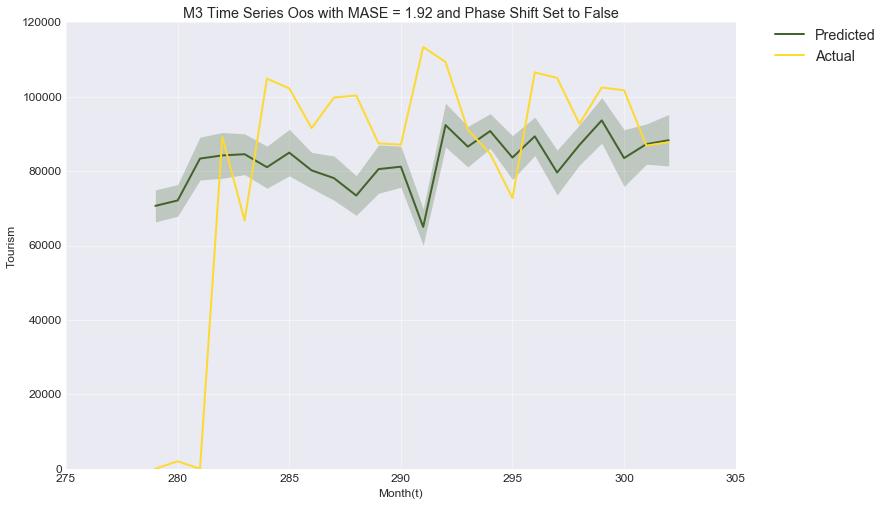

In [156]:
plot_predictions(series_id='m3',pred_type='oos',phase_shift=False)

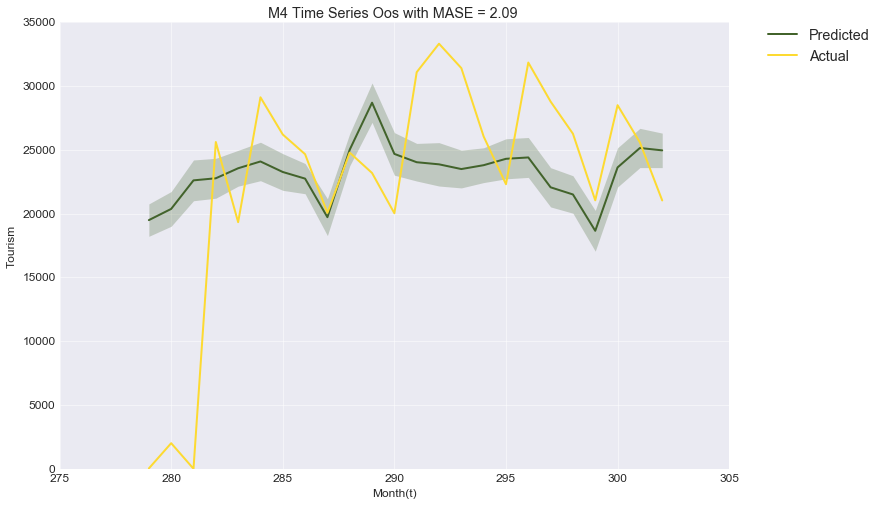

In [90]:
plot_predictions(series_id='m4',pred_type='oos',phase_shift=False)

### Analysis of OOS Data

Upon further inspection I noticed that the first three values of each series seemed to be filler data. The Kaggle post mentioned that the OOS data should only contain 24 records (for the monthly series), but Predata provided me with 27. Also, the first three records were essentially the same across all series ids.

The two data visualizations below (in-sample followed by oos) show the variance across all monthly timseries as the time index is varied. The dark red line shows the average time series value across all series ids for that period, and the light red shows standard deviation above and below the average. There is absolutely no variation (no light red spread) in the beginning -- nearly all series ids have values of 1. After 3 periods the variance returns to normal. 

In summary, it seems that there is a data quality issue. 

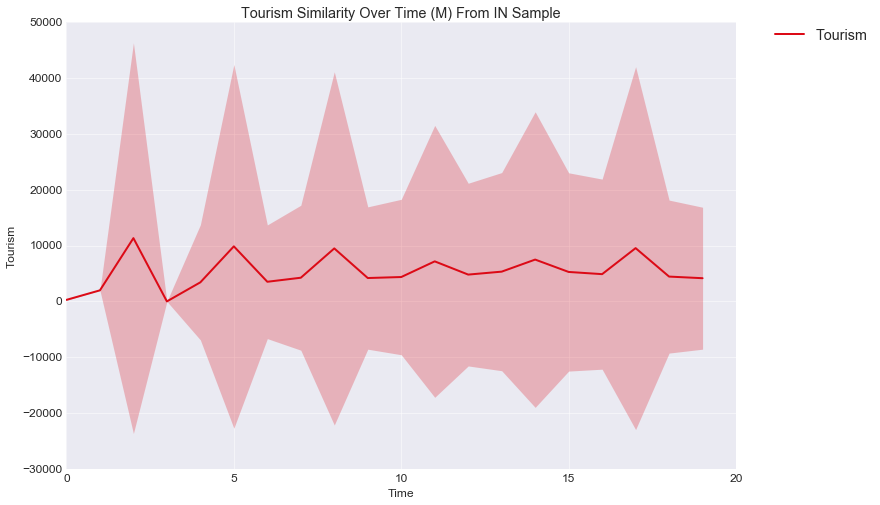

In [125]:
plot_all_ts_similarity(sample_type='in',series_type='m')

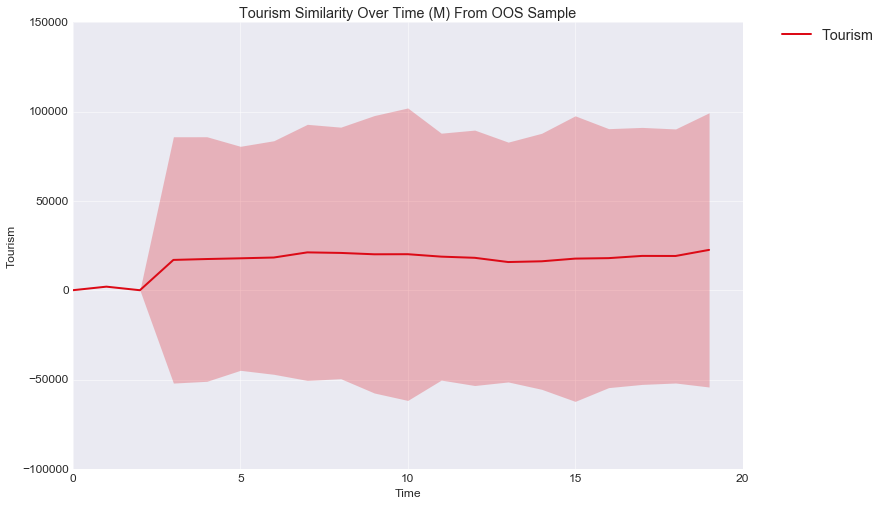

In [126]:
plot_all_ts_similarity(sample_type='oos',series_type='m')

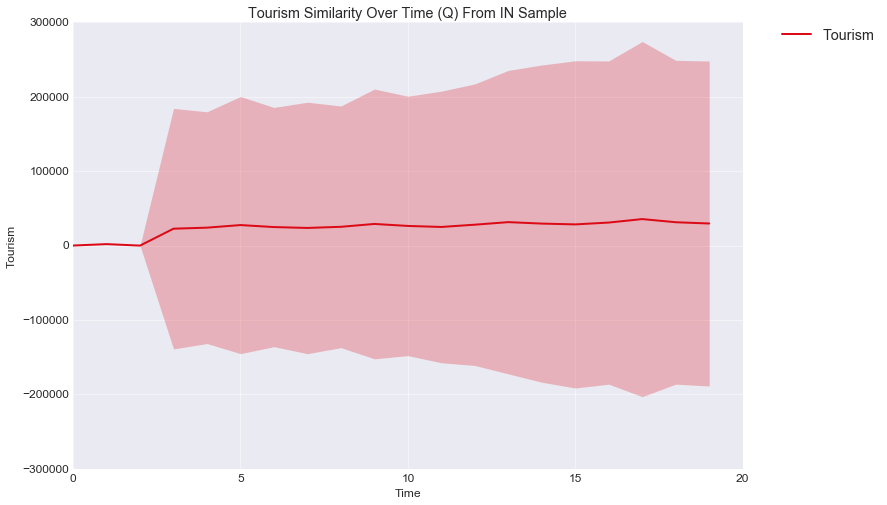

In [127]:
plot_all_ts_similarity(sample_type='in',series_type='q')

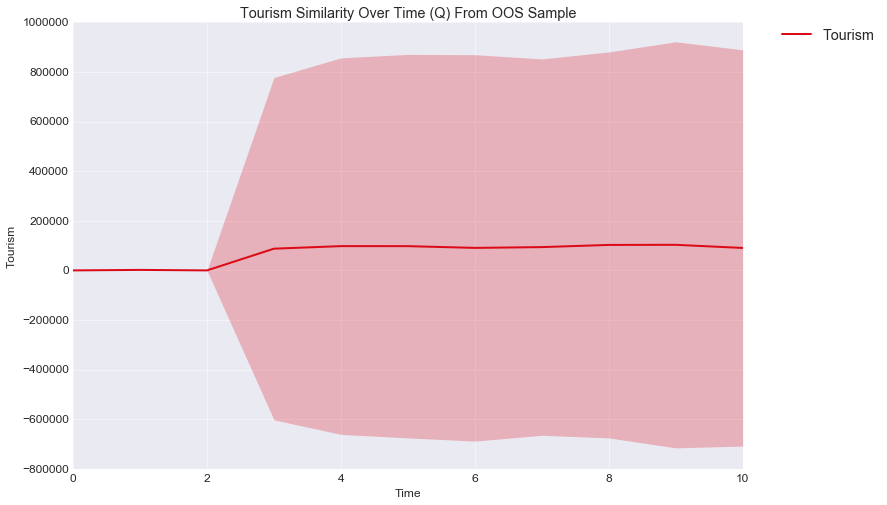

In [128]:
plot_all_ts_similarity(sample_type='oos',series_type='q')

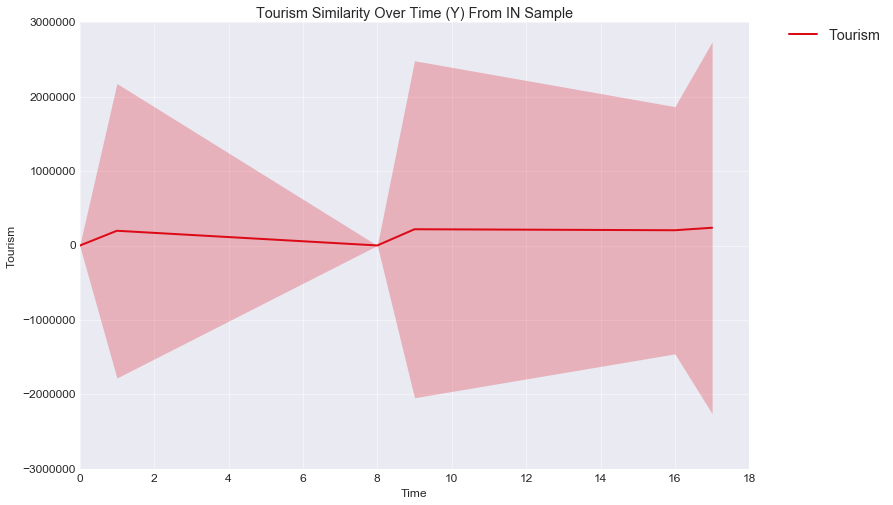

In [129]:
plot_all_ts_similarity(sample_type='in',series_type='y')

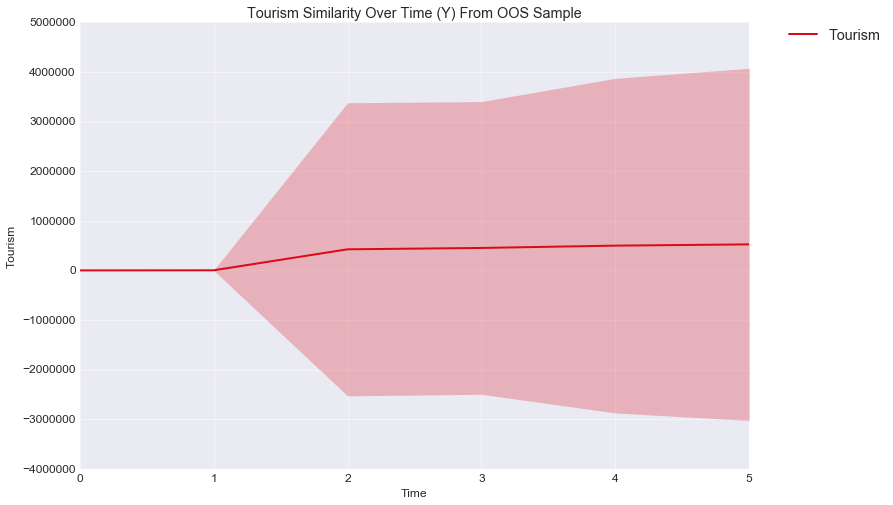

In [130]:
plot_all_ts_similarity(sample_type='oos',series_type='y')

### Applying OOS Phase Shift

After applying the phase shift (ignoring the first three records in the OOS dataset) the model performance more closely matches the quality of the predictions on the validation dataset. The peaks in the predictions now match the actual peaks, in some cases very closely.

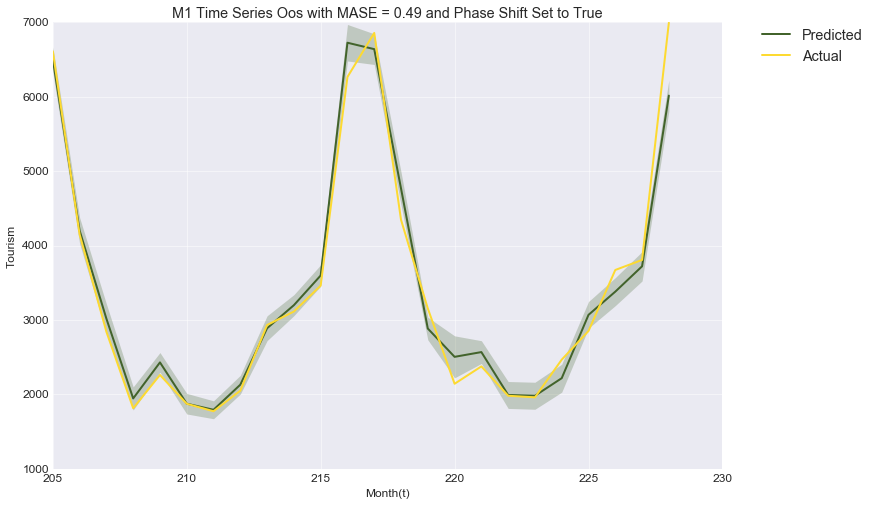

In [150]:
plot_predictions(series_id='m1',pred_type='oos',phase_shift=True)

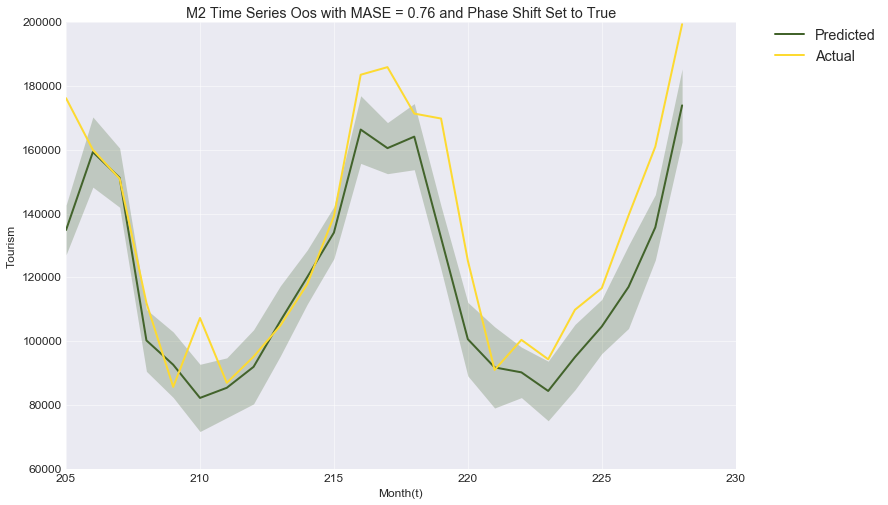

In [152]:
plot_predictions(series_id='m2',pred_type='oos',phase_shift=True)

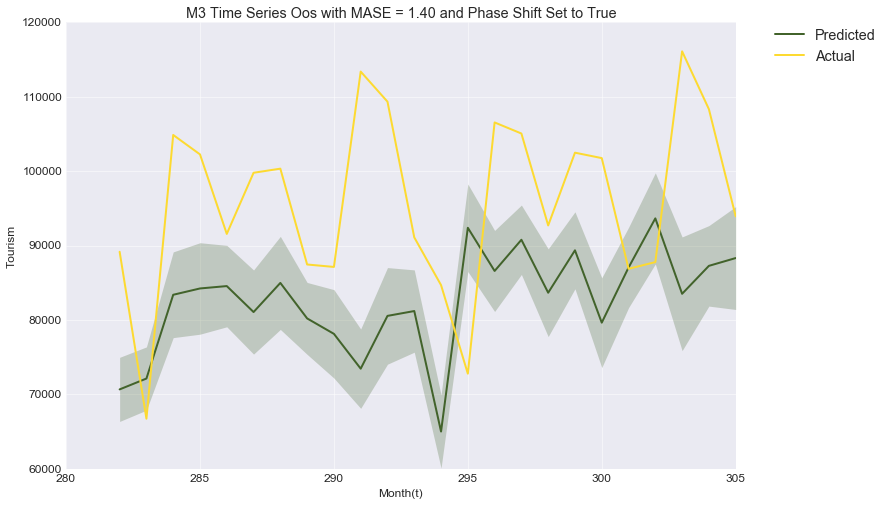

In [153]:
plot_predictions(series_id='m3',pred_type='oos',phase_shift=True)

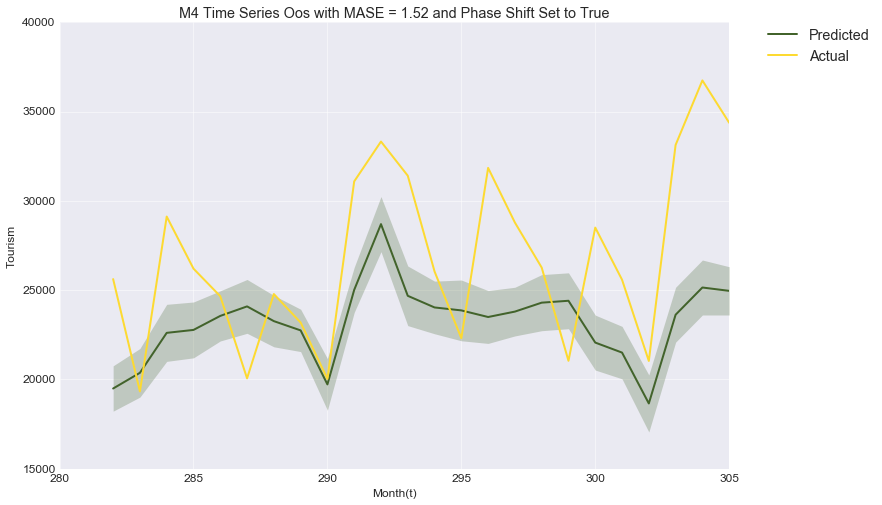

In [155]:
plot_predictions(series_id='m4',pred_type='oos',phase_shift=True)

### Forecast Horizon Length vs Prediction Error

For each series id I trained a separate model on each forecast horizon (meaning one model for predicting 1 month ahead, a separate model for predicting 2 months ahead, etc.). I expeted models with longer forecast horizons to have greater errors, but as the graphs below show, this was not always the case. The data is rather noisy, and perhaps the error shape that I expect to see would become more apparent if I aggreated these errors across many models. 

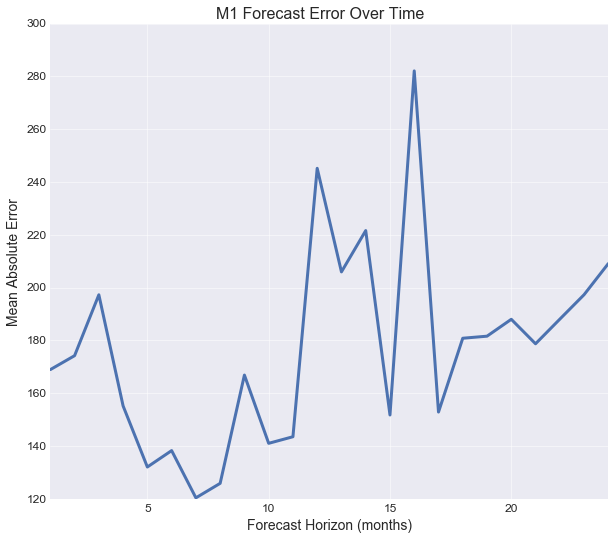

In [5]:
series_id = 'm1'
plot_horizon_error(series_id)

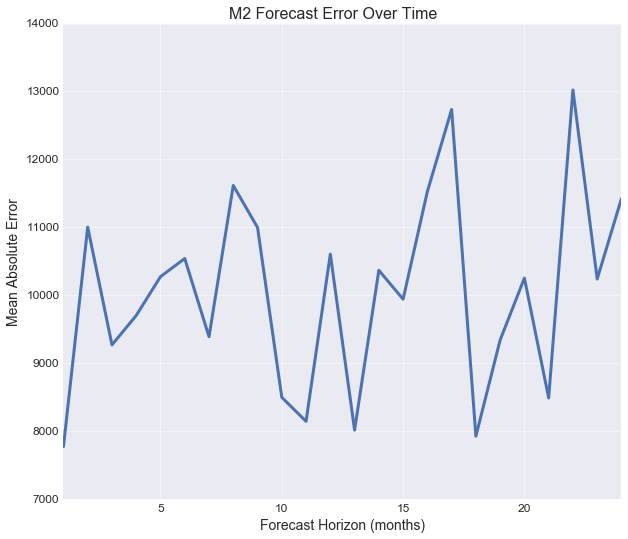

In [6]:
series_id = 'm2'
plot_horizon_error(series_id)

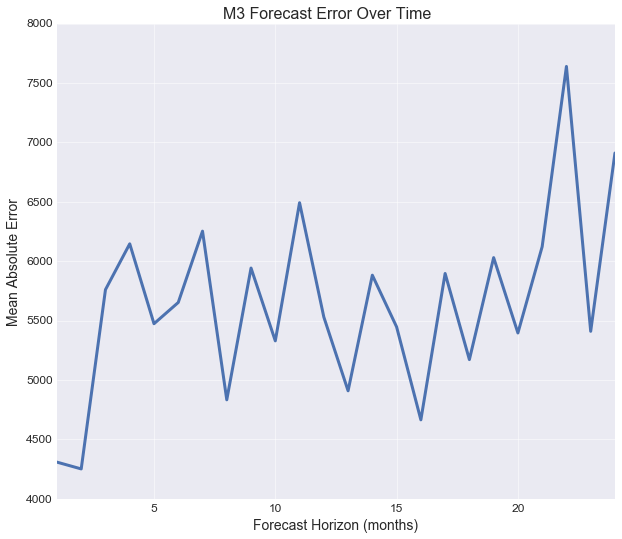

In [64]:
series_id = 'm3'
plot_horizon_error(series_id)

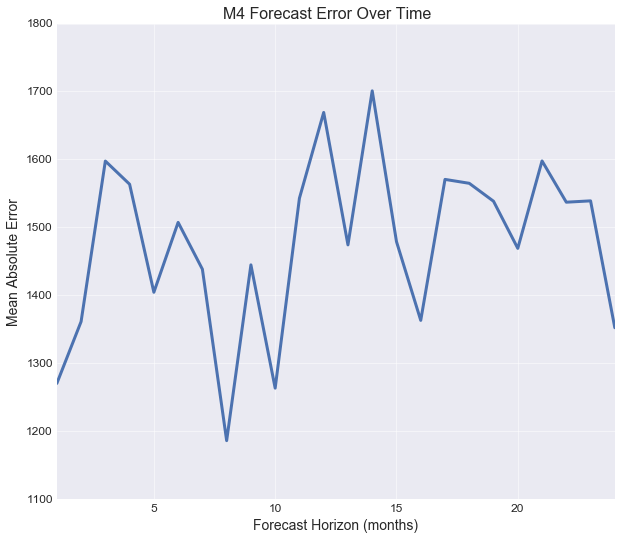

In [7]:
series_id = 'm4'
plot_horizon_error(series_id)

### Checking for Autocorrleated Cross Validation Model Errors

I use TPOT to automate the model training process. TPOT internally uses cross validation for model selection and hyper parameter tuning. Cross validation breaks down when model errors exhibit autocorrelation, so it's something that needs to be checked. It's not easy for me to check for this behavior among all of the models that TPOT trains, so I randomly picked a series ID and forecast horizon and inspected the errors visually. There does not seem to be any autocorrellation among the errors below, which is sufficient for me to feel comfortable relying on TPOT's use of cross validation. 

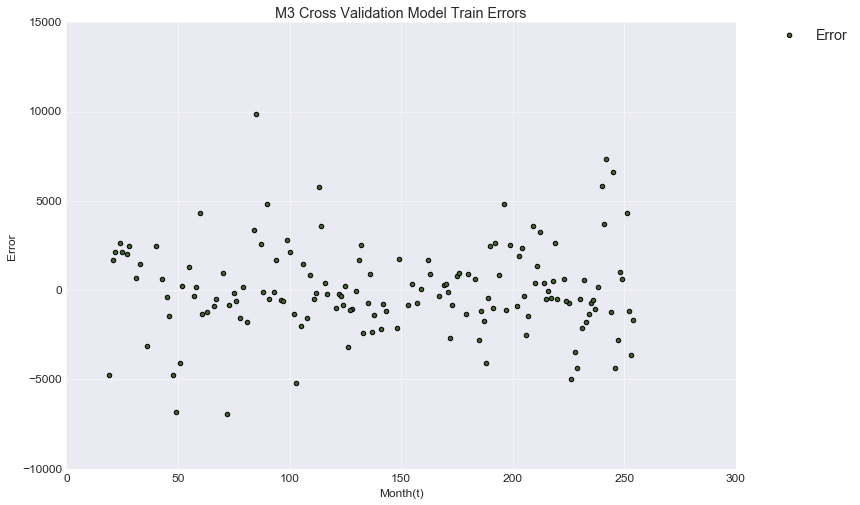

In [8]:
plot_train_errors(series_id='m3',horizon=1)

In [16]:
series_ids = []
for i in range(1,15):
    series_id = 'm'+str(i)
    series_ids.append(series_id)
    
diffs = []
    
for series_id in series_ids:
    sample_type = 'validation'
    mase_many_models = get_mase(series_id,sample_type,phase_shift=True)

    mase_recusive_model = get_recursive_mase(
        series_id=series_id,
        pred_type=sample_type,
        phase_shift=True)
    diff = mase_many_models - mase_recusive_model
    diffs.append(diff)
    print('{series_id}: {diff}'.format(series_id=series_id,diff=diff))

m1: -0.9199993099915769
m2: -1.0769164572164476
m3: -0.15218488333179292
m4: 0.06567465912575532
m5: 0.023424107767157087
m6: 0.15067857472038715
m7: 0.029646837871238008
m8: 0.17252679051456532
m9: 0.6818644919080556
m10: 0.09718650625969572
m11: -0.12040853879001467
m12: -0.28861051549633876
m13: 0.23798466740763602
m14: 0.4129475875259545


In [17]:
import numpy as np

np.sum(diffs)

-0.686185481725726

In [18]:
np.mean(diffs)

-0.049013248694694714

In [19]:
np.median(diffs)

0.04766074849849666